In [4]:
# pip install
!pip install -r requirements.txt
# Imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
plt.style.use(['science','no-latex'])
from matplotlib import ticker
import numpy as np
import pandas as pd
from pprint import pprint

# Module imports
from periodic_table import *
from utils import *
print("Imported all.")

Imported all.


In [5]:
# Open data file
physics_model = "shielding_5cm"
file_dir = f"./assets/{physics_model}/A_Z_vol_count-all.txt"
columns = ["Mass Number", "Atomic Number", "Detector Volume", "Counts"]
df = open_data(file_dir, columns)

In [6]:
# Add in isotope data
add_isotope_data(df)
# Reorder columns
df = df[["Iso Symbol","Atomic Number","Mass Number","Counts", "Detector Volume","Production Yield","Stable","Half Life (s)","Decay Modes (m, b, q MeV)","Max Q-Value","Plot Colour"]]

# Add Production (/yr)

In [7]:
# Simulation length = years * nanoseconds
year_in_nano = (3.154 * 10**16)
year_in_sec = (3.154 * 10**7)
sim_length = 29.01
df["Production (/yr)"] = df["Counts"] / sim_length

# Add count per muon

In [8]:
# number of muons per year
muon_no = (3.447 * 10**6)
df["Count per Muon"] = df["Production (/yr)"] / muon_no
# Normalise
df["Count per Muon"] = (df["Count per Muon"] - df["Count per Muon"].min()) / (df["Count per Muon"].max() - df["Count per Muon"].min())
df["Count per Muon"].mean()

0.019257544021997572

# Clean unstable isotopes into two datasets

In [28]:
df_unstable = df[df["Stable"] == False]
df_unstable = df_unstable.reset_index()
df_stable = df[df["Stable"] == True]
df_stable = df_stable.reset_index()
#df_unstable, df_stable

Number of stable isotopes: 43
Number of unstable isotopes: 148


In [10]:
# Data analysis
print(f"Total average production yield per muon: {round(df['Count per Muon'].mean(), 5)}")
print(f"Unstable average production yield per muon: {round(df_unstable['Count per Muon'].mean(), 5)}")
print(f"Stable average production yield per muon: {round(df_stable['Count per Muon'].mean(), 5)}")

Total average production yield per muon: 0.01926
Unstable average production yield per muon: 0.00762
Stable average production yield per muon: 0.05564


# Plot All

Total no. of isotopes: 185
No. stable of isotopes: 43
No. unstable of isotopes: 142


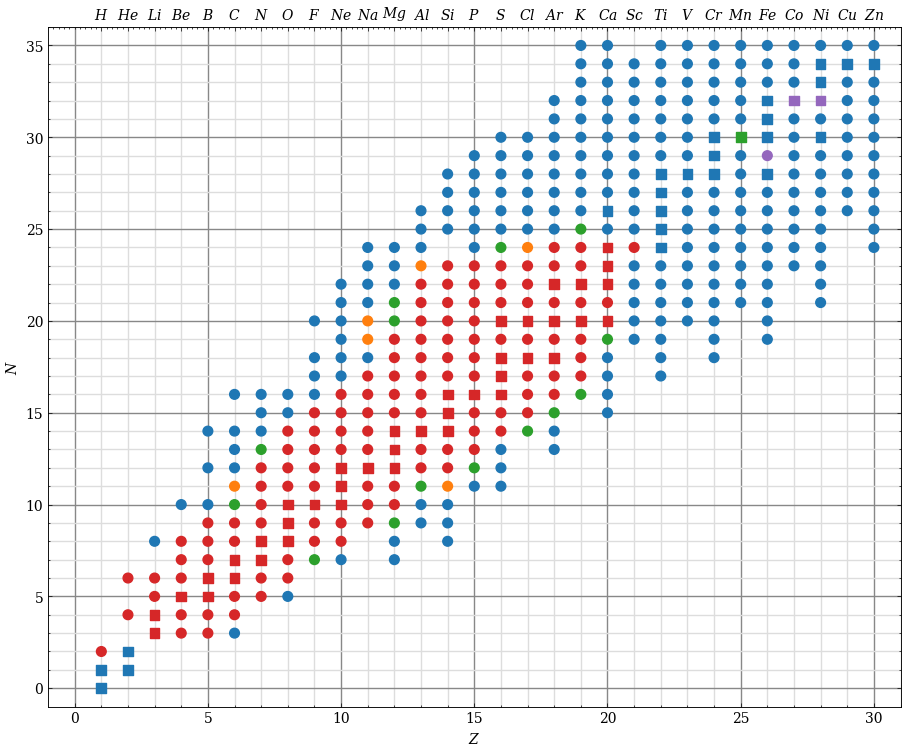

In [38]:
PTS_PER_INCH = 72

df_plot = df

element_symbols = [
 'H', 'He', 'Li', 'Be',  'B',  'C',  'N',  'O',  'F', 'Ne', 'Na', 'Mg', 'Al',
'Si',  'P',  'S', 'Cl', 'Ar',  'K', 'Ca', 'Sc', 'Ti',  'V', 'Cr', 'Mn', 'Fe',
'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr',  'Y',
'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te',
 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb',
'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta',  'W', 'Re', 'Os', 'Ir', 'Pt',
'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa',
 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf',
'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts',
'Og'
]

def get_marker_size(ax, nx, ny):
    """Determine the appropriate marker size (in points-squared) for ax."""
    # Get Axes width and height in pixels.
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    # Spacing between scatter point centres along the narrowest dimension.
    spacing = min(width, height) * PTS_PER_INCH / min(nx, ny)
    # Desired radius of scatter points.
    rref =  spacing / 2 * 0.5
    # Initial scatter point size (area) in pt^2.
    s = np.pi * rref**2
    return s

stable_count = 0
unstable_count = 0

isotopes_stable = {}
isotopes_unstable = {}
for line in open('isotopes.txt'):
    line = line.rstrip()
    halflife = line[10:]
    if halflife == 'None':
        continue
    fields = line[:10].split('-')
    symbol = fields[0]
    A = int(fields[1].split()[0])
    Z = int(element_symbols.index(symbol)) + 1
    N = A - Z
    halflife = float(halflife)
    if Z < 31 and N < 36:
        checkTPC = df_plot[(df_plot["Mass Number"] == A) & (df_plot["Atomic Number"] == Z) & (df_plot["Detector Volume"] == 11)]
        checkBUFFERS = df_plot[(df_plot["Mass Number"] == A) & (df_plot["Atomic Number"] == Z) & ((df_plot["Detector Volume"] == 7) | (df_plot["Detector Volume"] == 9))]
        checkELSE = df_plot[(df_plot["Mass Number"] == A) & (df_plot["Atomic Number"] == Z) & ~((df_plot["Detector Volume"] == 7) | (df_plot["Detector Volume"] == 9) | (df_plot["Detector Volume"] == 11))]
        # if unstable
        if halflife >= 0:
            unstable_count += 1
            # if in both - red
            if not checkTPC.empty and not checkBUFFERS.empty:
                isotopes_unstable[(N, Z)] = np.array([214, 39, 40]) / 255
            # If in TPC - orange
            elif not checkTPC.empty:
                isotopes_unstable[(N, Z)] = np.array([255, 127, 14]) / 255
            # If in buffers - green
            elif not checkBUFFERS.empty:
                isotopes_unstable[(N, Z)] = np.array([44, 160, 44]) / 255
            # If in elsewhere - purple
            elif not checkELSE.empty:
                isotopes_unstable[(N, Z)] = np.array([148, 103, 189]) / 255
            # Else blue
            else:
                isotopes_unstable[(N, Z)] = np.array([31, 119, 180]) / 255
                unstable_count -= 1
        # if stable
        else:
            stable_count += 1
            # if in both - red
            if not checkTPC.empty and not checkBUFFERS.empty:
                isotopes_stable[(N, Z)] = np.array([214, 39, 40]) / 255
            # If in TPC - orange
            elif not checkTPC.empty:
                isotopes_stable[(N, Z)] = np.array([255, 127, 14]) / 255
             # If in buffers - green
            elif not checkBUFFERS.empty:
                isotopes_stable[(N, Z)] = np.array([44, 160, 44]) / 255
            # If in elsewhere - purple
            elif not checkELSE.empty:
                isotopes_stable[(N, Z)] = np.array([148, 103, 189]) / 255
            # Else blue
            else:
                stable_count -= 1
                isotopes_stable[(N, Z)] = np.array([31, 119, 180]) / 255
                
print(f"Total no. of isotopes: {stable_count + unstable_count}")
print(f"No. stable of isotopes: {stable_count}")
print(f"No. unstable of isotopes: {unstable_count}")

k_s, colors_s = zip(*isotopes_stable.items())
N_s, Z_s = zip(*k_s)
k_u, colors_u = zip(*isotopes_unstable.items())
N_u, Z_u = zip(*k_u)
maxN, maxZ = max(max(N_s), max(N_u)) + 1, max(max(Z_s), max(Z_u)) + 1

# Initial dimensions of the plot
w, h = 1100, 900
DPI_nuc = 100
w_in, h_in = w / DPI_nuc, h / DPI_nuc

fig, ax = plt.subplots(figsize=(w_in, h_in), dpi=DPI_nuc)

s = get_marker_size(ax, maxZ, maxN)
sc1 = ax.scatter(Z_s, N_s, c=colors_s, s=s, marker="s")
sc1 = ax.scatter(Z_u, N_u, c=colors_u, s=s, marker="o")

# Grid on both major and minor ticks
loc = ticker.MultipleLocator(base=5)
ax.xaxis.set_minor_locator(loc)
ax.yaxis.set_minor_locator(loc)
ax.grid(which='major', color='#888888', lw=1)
ax.grid(which='minor', color='#dddddd', lw=1)
plt.minorticks_on()
ax.set_axisbelow(True)

ax.set_xlim(-1, maxZ)
ax.set_ylim(-1, maxN)
ax.set_xlabel(r'$Z$')
ax.set_ylabel(r'$N$')
# Noble gas elements on the top x-axis.
topax = ax.twiny()
top_axis = [r'$H$', r'$He$', r'$Li$', r'$Be$',  r'$B$',  r'$C$',  r'$N$',  r'$O$',  r'$F$', r'$Ne$', r'$Na$', r'$Mg$', r'$Al$',
r'$Si$',  r'$P$',  r'$S$', r'$Cl$', r'$Ar$',  r'$K$', r'$Ca$', r'$Sc$', r'$Ti$',  r'$V$', r'$Cr$', r'$Mn$',r'$Fe$',r'$Co$', r'$Ni$', r'$Cu$', r'$Zn$']
topax.set_xticks(np.linspace(1, len(top_axis), len(top_axis)))
topax.set_xticklabels(top_axis)
topax.set_xlim(-1, maxZ)
plt.savefig('./img/nuclides-chart_shielding.png', dpi=DPI_nuc)
plt.show()

# Volumes not TPC or Buffers

In [12]:
other_volumes_df = df_plot[~((df_plot["Detector Volume"] == 7) | (df_plot["Detector Volume"] == 9) | (df_plot["Detector Volume"] == 11))]
other_volumes_df

,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (s),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
0,H 1-3,1,3,547,5,1.437945e-05,False,3.890000e+08,"[[B-, 1.0, 0.019]]",0.019,red,18.8556,0.000145945
1,H 1-3,1,3,548,6,1.440574e-05,False,3.890000e+08,"[[B-, 1.0, 0.019]]",0.019,red,18.89,0.000146212
3,H 1-3,1,3,444,8,1.167181e-05,False,3.890000e+08,"[[B-, 1.0, 0.019]]",0.019,red,15.3051,0.000118413
5,H 1-3,1,3,694,10,1.824377e-05,False,3.890000e+08,"[[B-, 1.0, 0.019]]",0.019,red,23.9228,0.000185238
28,Li 3-6,3,6,10,6,2.628785e-07,True,inf,None,NaN,blue,0.344709,2.40568e-06
31,Li 3-6,3,6,1,10,2.628785e-08,True,inf,None,NaN,blue,0.0344709,0
49,Li 3-8,3,8,2,8,5.257570e-08,False,8.400000e-01,"[[B-, 1.0, 16.005], [BA, 1.0, 0.0]]",16.005,red,0.0689417,2.67298e-07
78,B 5-10,5,10,1,10,2.628785e-08,True,inf,None,NaN,blue,0.0344709,0
88,B 5-11,5,11,1,10,2.628785e-08,True,inf,None,NaN,blue,0.0344709,0
101,C 6-12,6,12,2,10,5.257570e-08,True,inf,None,NaN,blue,0.0689417,2.67298e-07


In [13]:
# Plot total
figsize=(20,40)
# Plotting
#fig, ax = plt.subplots(figsize=figsize)
#ax.barh(df.index, df["Production Yield"], log=True, color=df["Plot Colour"])
#ax.set_yticklabels(df["Iso Symbol"])
#ax.set_yticks(np.arange(len(df)))
#ax.set_xlabel("Production Yield")
#ax.set_ylabel("Isotope")
#ax.set_title("All Isotopes")
#red_patch = mpatches.Patch(color="red", label="Unstable")
#blue_patch = mpatches.Patch(color="blue", label="Stable")
#ax.legend(handles=[red_patch, blue_patch], loc=0)
#plt.show()

# Plot unstable

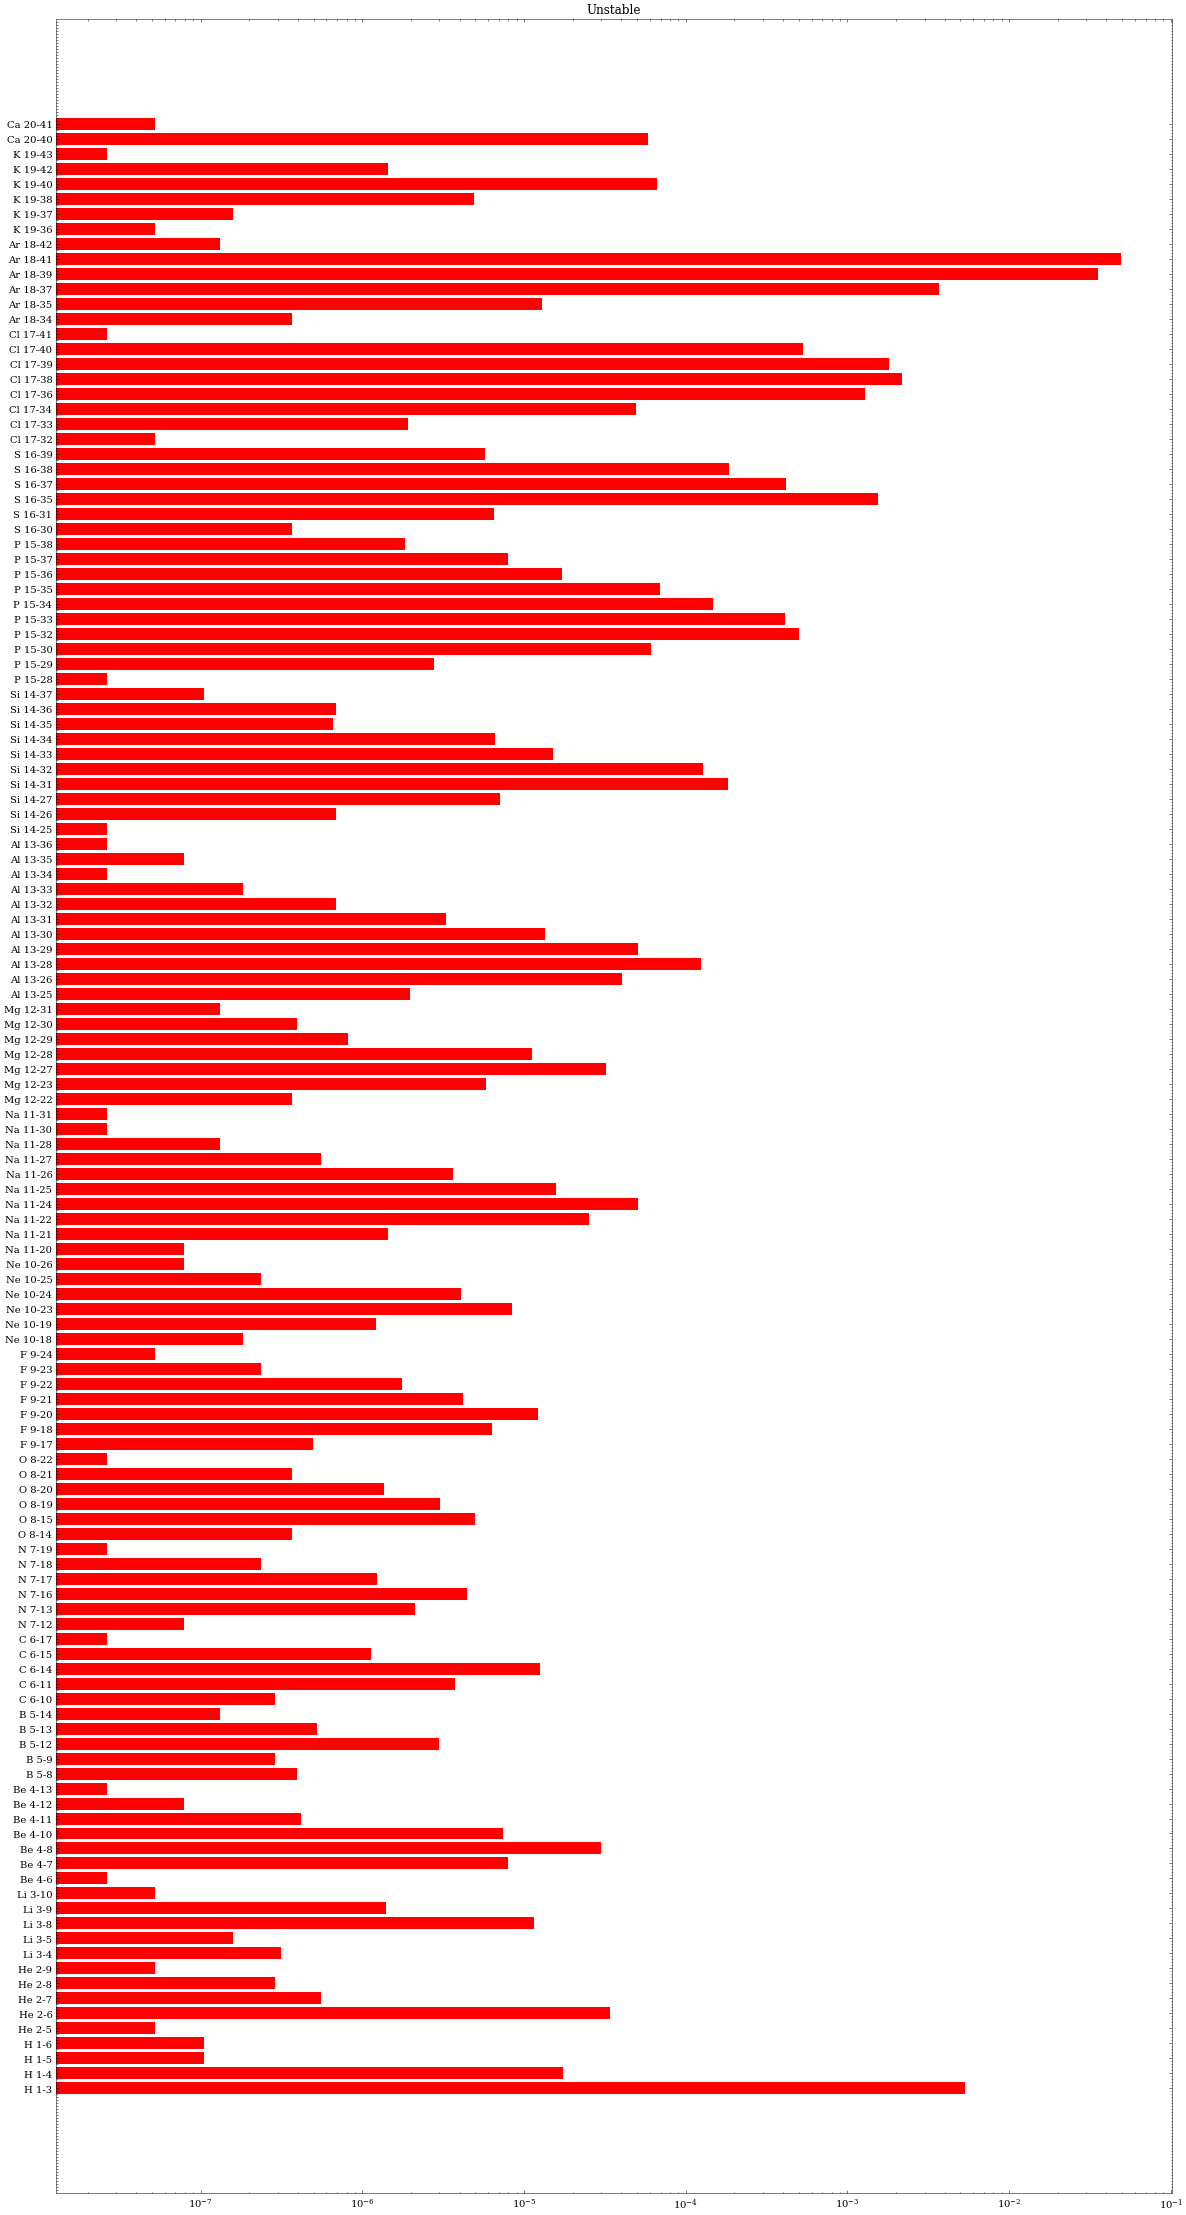

In [14]:
fig_un, ax_un = plt.subplots(figsize=figsize)
df_unstable_TPC = df_unstable[df_unstable["Detector Volume"] == 11].reset_index(drop=True)
ax_un.barh(df_unstable_TPC.index, df_unstable_TPC["Production Yield"], log=True, color=df_unstable_TPC["Plot Colour"])
ax_un.set_yticklabels(df_unstable_TPC["Iso Symbol"])
ax_un.set_yticks(np.arange(len(df_unstable_TPC)))
ax.set_xlabel("Production Yield")
ax.set_ylabel("Isotope")
ax_un.set_title("Unstable")
plt.show()

# Plot stable

Text(0.5, 1.0, 'Stable')

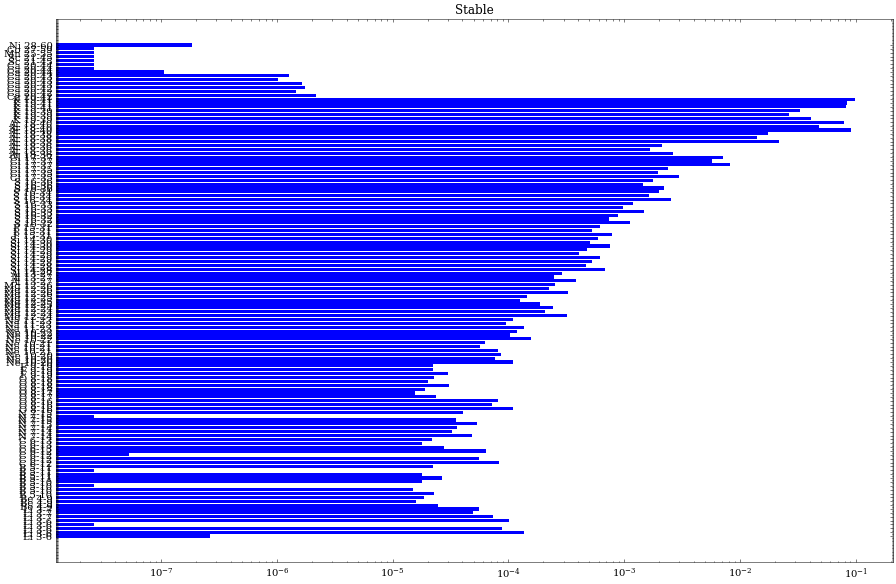

In [15]:
fig_s, ax_s = plt.subplots(figsize=(15,10))
ax_s.barh(df_stable.index, df_stable["Production Yield"], log=True, color=df_stable["Plot Colour"])
ax_s.set_yticklabels(df_stable["Iso Symbol"])
ax_s.set_yticks(np.arange(len(df_stable)))
ax.set_xlabel("Production Yield")
ax.set_ylabel("Isotope")
ax_s.set_title("Stable")
#plt.show()

# Ratio of counts in each volume
key: 7, 9, 11

val: Outer, Inner, TPC

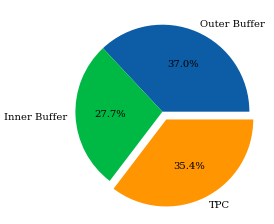

In [41]:
df_OB = df[df["Detector Volume"] == 7]
df_IB = df[df["Detector Volume"] == 9]
df_TPC = df[df["Detector Volume"] == 11]
plt.pie(x=[df_OB["Counts"].sum(), df_IB["Counts"].sum(), df_TPC["Counts"].sum()], autopct='%1.1f%%', explode=[0,0,0.1], labels=["Outer Buffer", "Inner Buffer", "TPC"])
plt.savefig('./img/volume-ratio.png', dpi=800)
plt.show()

In [17]:
# Ratio of stable to unstable
print(f'{df_stable["Counts"].sum() / df_unstable["Counts"].sum()}')

2.3378680435904986


# Looking for excess yields

In [18]:
# Sort df by counts
df_count_sort = df.sort_values(["Counts"], ascending=False)
# Try to highlight mass numbers > 40
# df_count_sort.style.apply(lambda x: ["background-color: red" if x["Mass Number"] > 40 else ""], axis = 1)
# Total df
df_count_sort.head(60)

,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (s),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
500,K 19-41,19,41,3741142,11,0.098347,True,inf,None,NaN,blue,128960,1
485,Ar 18-40,18,40,3434605,7,0.090288,True,inf,None,NaN,blue,118394,0.918063
499,K 19-41,19,41,3183656,9,0.083691,True,inf,None,NaN,blue,109743,0.850985
498,K 19-41,19,41,3102750,7,0.081565,True,inf,None,NaN,blue,106954,0.829359
487,Ar 18-40,18,40,3005414,11,0.079006,True,inf,None,NaN,blue,103599,0.803341
497,Ar 18-41,18,41,1877615,11,0.049358,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,64723,0.501883
486,Ar 18-40,18,40,1831156,9,0.048137,True,inf,None,NaN,blue,63121.5,0.489464
474,Ar 18-39,18,39,1680420,7,0.044175,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red,57925.5,0.449173
496,Ar 18-41,18,41,1597863,9,0.042004,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,55079.7,0.427106
477,K 19-39,19,39,1564923,7,0.041138,True,inf,None,NaN,blue,53944.3,0.418301


### Unstable (Counts)
To get a sense of most produced isotopes

In [19]:
# Unstable df sorted by counts
df_count_sort[df_count_sort["Stable"] == False].head(60)

,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (s),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
497,Ar 18-41,18,41,1877615,11,0.049358,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,64723,0.501883
474,Ar 18-39,18,39,1680420,7,0.044175,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red,57925.5,0.449173
496,Ar 18-41,18,41,1597863,9,0.042004,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,55079.7,0.427106
495,Ar 18-41,18,41,1557116,7,0.040933,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,53675.1,0.416214
476,Ar 18-39,18,39,1352522,11,0.035555,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red,46622.6,0.361526
475,Ar 18-39,18,39,1085723,9,0.028541,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red,37425.8,0.290211
2,H 1-3,1,3,259941,7,0.006833,False,3.890000e+08,"[[B-, 1.0, 0.019]]",0.019,red,8960.39,0.0694815
6,H 1-3,1,3,203503,11,0.005350,False,3.890000e+08,"[[B-, 1.0, 0.019]]",0.019,red,7014.93,0.0543957
4,H 1-3,1,3,172996,9,0.004548,False,3.890000e+08,"[[B-, 1.0, 0.019]]",0.019,red,5963.32,0.0462412
447,Ar 18-37,18,37,151905,7,0.003993,False,3.030000e+06,"[[EC, 1.0, 0.814]]",0.814,red,5236.3,0.0406037


### All (heavy (40>))
Any heavy isotopes

In [20]:
df.sort_values(["Atomic Number", "Mass Number"], ascending=False).head(50)

,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (s),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
527,Ni 28-60,28,60,7,6,1.840150e-07,True,inf,None,NaN,blue,0.241296,1.60379e-06
526,Co 27-59,27,59,1,6,2.628785e-08,True,inf,None,NaN,blue,0.0344709,0
525,Fe 26-55,26,55,1,6,2.628785e-08,False,8.660000e+07,"[[EC, 1.0, 0.231]]",0.231,red,0.0344709,0
524,Mn 25-55,25,55,1,7,2.628785e-08,True,inf,None,NaN,blue,0.0344709,0
522,Sc 21-45,21,45,1,9,2.628785e-08,True,inf,None,NaN,blue,0.0344709,0
523,Sc 21-45,21,45,1,11,2.628785e-08,True,inf,None,NaN,blue,0.0344709,0
519,Ca 20-44,20,44,4,7,1.051514e-07,True,inf,None,NaN,blue,0.137883,8.01894e-07
520,Ca 20-44,20,44,1,9,2.628785e-08,True,inf,None,NaN,blue,0.0344709,0
521,Ca 20-44,20,44,1,11,2.628785e-08,True,inf,None,NaN,blue,0.0344709,0
515,Ca 20-43,20,43,62,7,1.629847e-06,True,inf,None,NaN,blue,2.13719,1.63052e-05


### Unstable all (Half-life)

In [21]:
df_unstable_sort_life = df_unstable.sort_values("Half Life (s)", ascending=True)
df_unstable_sort_life.head(60)

,index,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (s),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
30,60,He 2-9,2,9,2,11,5.257570e-08,False,0.000000e+00,"[[N, 1.0, 1.27]]",1.270,red,0.0689417,2.67298e-07
28,58,He 2-9,2,9,1,7,2.628785e-08,False,0.000000e+00,"[[N, 1.0, 1.27]]",1.270,red,0.0344709,0
46,72,Li 3-10,3,10,2,11,5.257570e-08,False,0.000000e+00,"[[N, 1.0, 0.025]]",0.025,red,0.0689417,2.67298e-07
45,71,Li 3-10,3,10,1,9,2.628785e-08,False,0.000000e+00,"[[N, 1.0, 0.025]]",0.025,red,0.0344709,0
44,70,Li 3-10,3,10,4,7,1.051514e-07,False,0.000000e+00,"[[N, 1.0, 0.025]]",0.025,red,0.137883,8.01894e-07
7,7,H 1-4,1,4,859,7,2.258126e-05,False,0.000000e+00,"[[N, 1.0, 2.88]]",2.880,red,29.6105,0.000229342
8,8,H 1-4,1,4,582,9,1.529953e-05,False,0.000000e+00,"[[N, 1.0, 2.88]]",2.880,red,20.062,0.0001553
9,9,H 1-4,1,4,662,11,1.740256e-05,False,0.000000e+00,"[[N, 1.0, 2.88]]",2.880,red,22.8197,0.000176684
29,59,He 2-9,2,9,1,9,2.628785e-08,False,0.000000e+00,"[[N, 1.0, 1.27]]",1.270,red,0.0344709,0
31,10,Li 3-4,3,4,17,7,4.468935e-07,False,7.870000e-23,"[[P, 1.0, 3.103]]",3.103,red,0.586005,4.27677e-06


# Looking at production yields

### Unstable (Production yield > 0.1%)

In [22]:
# Sets min production yield to be 1%
high_prod_yield = df_unstable[(df_unstable["Production Yield"] > 0.0001)]
high_prod_yield

,index,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (s),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
2,2,H 1-3,1,3,259941,7,0.006833,False,3.890000e+08,"[[B-, 1.0, 0.019]]",0.019,red,8960.39,0.0694815
4,4,H 1-3,1,3,172996,9,0.004548,False,3.890000e+08,"[[B-, 1.0, 0.019]]",0.019,red,5963.32,0.0462412
6,6,H 1-3,1,3,203503,11,0.005350,False,3.890000e+08,"[[B-, 1.0, 0.019]]",0.019,red,7014.93,0.0543957
230,295,Al 13-28,13,28,6327,7,0.000166,False,1.340000e+02,"[[B-, 1.0, 4.642]]",4.642,red,218.097,0.00169093
231,296,Al 13-28,13,28,4419,9,0.000116,False,1.340000e+02,"[[B-, 1.0, 4.642]]",4.642,red,152.327,0.00118092
232,297,Al 13-28,13,28,4713,11,0.000124,False,1.340000e+02,"[[B-, 1.0, 4.642]]",4.642,red,162.461,0.00125951
262,337,Si 14-31,14,31,8951,7,0.000235,False,9.440000e+03,"[[B-, 1.0, 1.492]]",1.492,red,308.549,0.00239232
263,338,Si 14-31,14,31,5885,9,0.000155,False,9.440000e+03,"[[B-, 1.0, 1.492]]",1.492,red,202.861,0.00157278
264,339,Si 14-31,14,31,6949,11,0.000183,False,9.440000e+03,"[[B-, 1.0, 1.492]]",1.492,red,239.538,0.00185719
265,351,Si 14-32,14,32,5932,7,0.000156,False,4.830000e+09,"[[B-, 1.0, 0.224]]",0.224,red,204.481,0.00158535
